# Introduction
This notebook was used to create Figure 1 of the 'Do You Catch My Drift' short paper submission to the 2023 K-CAP conference. While properly commented, the project remains a work in progress, meaning that some redundancies and inefficiencies are still present within the notebook. However, all code necessary to recreate a figure showing the implicit structure of the used embeddings is present. Note that the used t-SNE implementation is stochastic, meaning that each time the notebook is run, the resulting visualisation will slightly differ. This could be solved by setting the seed, but this has not been implemented yet.

## Running instructions
- Open a terminal and navigate to the directory in which this notebook is stored.
- Ensure you have a working Latex installing (run `tex --version`). If not installed, the labels and titles within the figure will not be rendered properly.
- (optional) Initialise a new python environment and activate this environment.
- Run `pip install -r requirements.txt`
- Run `jupyter-notebook`

Note 1: This notebook has been tested on python version 3.10.4

Note 2: The pickled files were pickled using protocol version 4.

# Environment initialization

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib as mpl

import rdflib
from rdflib import URIRef

# matplotlib settings
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Serif'],'weight' : 'normal'})

# K nearest neighbour settings.
KNN_PARAMS = {'embed_size':128,
            'dist_metric':'euclidean',
            'dist_algorithm':'auto', # algorithm used for calculating the distances. Should not affect outcomes, only computational complexity
            'n_jobs': 10

}

# FB15K-237 id mappings
ENT_IDS = pd.read_table('./data/entity_ids.del', header=None, names=['idx', 'id'])
ENT_STRINGS = pd.read_table('./data/entity_strings.del', header=None, names=['id', 'label'])
TRAIN_GRAPH = pd.read_table('./data/train.txt', header=None, names=['subject','predicate','object'])

# Predicates that could be used for grouping purposes. Here, each group is determined by whether the entity occurs in the 'object' position for each triple in which the selected predicate occurs in the predicate position.
PREDICATES_OF_INTEREST= ['/location/country/capital','/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']


# Function definitions

In [3]:

def get_embed_df(embed_file):
    """
    Function to load an embedding from a pickled file.
    :param embed_file: Location where the pickle file is stored
    :return: Pandas dataframe of the embedding with the ID and label of all entities, along with the 128 dimensional embedding of this entity.
    """
    embed = pd.read_pickle(embed_file)

    # The provided pickle files have some artifacts that makes processing them difficult. Instead of using the provided IRIs and labels, the ones of the official documentation f FB15K-237 will be used.
    embed = embed.drop(['IRI'], axis=1)
    embed['idx'] = [int(s.split('_')[1]) for s in embed['label']]
    embed = embed.drop(['label'], axis=1)

    # Merge the embedding with the ids and labels of the FB15K-237 knowledge graph
    embed_df = embed.merge(ENT_IDS, how='left', on='idx', validate='one_to_one')
    embed_df = embed_df.merge(ENT_STRINGS, how='left', on='id', validate='one_to_one')


    # Reorganise the columns
    df_cols = embed_df.columns.to_list()
    embed_df = embed_df[df_cols[-3:]+df_cols[:-3]]
    return embed_df

# Validating that the function works
embed_file = './data/fb15K/fb15k_rescal_base_1.pkl'
embed_df = get_embed_df(embed_file)

In [3]:
embed_df

,idx,id,label,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,0,/m/027rn,Dominican Republic,-0.146256,-0.578089,0.177479,-0.049107,-0.012232,-0.221018,-0.062166,...,-0.088164,-0.201174,-0.104589,-0.312500,0.177850,-0.316693,-0.169334,0.489509,-0.129283,0.136784
1,1,/m/06cx9,Republic,-0.007571,0.003624,-0.021278,0.007038,0.143742,0.007194,0.078806,...,0.102966,0.106307,-0.305936,0.018397,-0.017043,0.030612,-0.075956,0.006920,-0.194404,0.033823
2,2,/m/017dcd,Mighty Morphin Power Rangers,0.379334,0.003005,0.046794,-0.017940,-0.015345,-0.325672,-0.052096,...,0.056260,0.253749,0.010514,0.045833,0.527376,-0.093880,0.051443,0.308512,0.073801,-0.035994
3,3,/m/06v8s0,Wendee Lee,0.022007,0.011509,0.196561,-0.233806,0.256252,0.004981,-0.049484,...,-0.032013,-0.105944,-0.298746,0.079982,0.126986,0.084194,-0.199518,0.035323,0.031453,0.033701
4,4,/m/07s9rl0,Drama (Film genre) #99,-0.037896,-0.135433,-0.015216,0.016388,0.027395,0.015850,-0.030004,...,0.138653,-0.000038,0.007315,-0.109590,0.591265,0.021446,-0.007714,-0.009263,0.035300,-0.049312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,14536,/m/0lyb_,Pulitzer Prize for Music,0.156724,-0.425432,0.386711,-0.529450,0.072928,-0.054657,-0.070003,...,0.312985,0.150014,-0.493349,-0.432039,0.301688,-0.218864,-0.003323,0.111815,-0.068142,0.110022
14537,14537,/m/027yjnv,2008 Tour de France,0.155785,-0.440503,0.352935,-0.523087,0.078991,-0.060392,-0.034393,...,0.307584,0.175281,-0.500532,-0.420084,0.330344,-0.224782,0.003309,0.096241,-0.103196,0.095560
14538,14538,/m/024030,Padma Vibhushan,0.176374,-0.415334,0.369348,-0.494535,0.043154,-0.076511,-0.061753,...,0.287199,0.133039,-0.507138,-0.434357,0.316673,-0.209397,-0.003766,0.110912,-0.061232,0.115784
14539,14539,/m/024tv_,Pakistan Peoples Party,0.170296,-0.427106,0.362223,-0.502987,0.086012,-0.059982,-0.055678,...,0.297980,0.149853,-0.474682,-0.421680,0.310461,-0.224609,0.011464,0.146867,-0.091780,0.103778


In [4]:
def get_label(id):
    """
    Simple function to extract the label of a entity based on id
    :param id: the id of the entity
    :return: the label of the entity
    """
    label = ENT_STRINGS.at[int(ENT_STRINGS.index[ENT_STRINGS['id'] == id][0]), 'label']
    return label

def get_groups(id, rel_df, selected_groups = 'all'):
    """
    Function used to return the group(s) to which an entity belongs
    :param id: the id of the entity
    :param rel_df: the dataframe in which all selected relations are listed with the entities that occur in the 'object' position of the selected relation
    :param selected_groups: The set of groups that should be considered
    :return: A list of groups to which the selected entity belongs
    """
    if selected_groups == 'all':
        groups = [row.predicate for _, row in rel_df.iterrows() if id in set(row.objects)]
    else:
        groups = [g for g in selected_groups if id in set(rel_df.loc[rel_df.predicate == g].objects.values[0])]
    return groups

def det_KNN(samples, embed, k = 100):
    """
    Wrapper function for running the KNN algorithm
    :param samples: The set of samples for which the nearest neighbour set should be determined
    :param embed: The embedding that should be used to determine the nearest neighbour set
    :param k: The number of nearest neighbours that should be determined
    :return: The k-nearest neighbour set of the selected entities using the provided embedding
    """
    model = NearestNeighbors(n_neighbors=k,
                         metric=KNN_PARAMS['dist_metric'],
                         algorithm=KNN_PARAMS['dist_algorithm'],
                         n_jobs=KNN_PARAMS['n_jobs']).fit(embed)
    return model.kneighbors(samples)


# Formatting of the FB15K-237 knowledge graph
The remaining functions require queries on the FB15K-237 knowledge graph. Hence, the following notebook cell load the graph into a rdflib Graph. To make visualisation of various groups of entities easier later in the notebook, additional analysis is applied to the graph, grouping entities according to the predicates that are connected to them in the graph.

In [5]:
# Loading of the rdflib Graph
g = rdflib.Graph()

for i, row in TRAIN_GRAPH.iterrows():
    s = rdflib.URIRef(f'{row["subject"]}')
    p = rdflib.URIRef(f'{row["predicate"]}')
    o = rdflib.URIRef(f'{row["object"]}')
    g.add((s, p, o))

In [6]:
len(g)

272115

In [6]:

# All/most relations in 'relation_ids.del' somehow related to locations. These have been determined by hand. The set is therefore in no way intended to be complete.
rel_dict = {
    13: '/film/film/release_date_s./film/film_regional_release_date/film_release_region',
    16: '/organization/organization/headquarters./location/mailing_address/country',
    28: '/film/film/country',
    35: '/government/legislative_session/members./government/government_position_held/district_represented',
    39: '/people/deceased_person/place_of_death',
    54: '/location/country/capital',
    56: '/location/hud_county_place/place',
    66: '/people/person/places_lived./people/place_lived/location',
    78: '/base/locations/continents/countries_within',
    83: '/organization/organization/headquarters./location/mailing_address/citytown',
    106: '/film/film/featured_film_locations',
    111: '/location/hud_county_place/county',
    127: '/base/biblioness/bibs_location/state',
    133: '/base/biblioness/bibs_location/country',
    135: '/location/administrative_division/country',
    144: '/base/aareas/schema/administrative_area/capital',
    147: '/film/film/distributors./film/film_film_distributor_relationship/region',
    150: '/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_location',
    151: '/people/ethnicity/geographic_distribution',
    157: '/olympics/olympic_games/participating_countries',
    160: '/music/artist/origin',
    163: '/time/event/locations',
    185: '/tv/tv_program/country_of_origin',
    190: '/location/us_county/county_seat',
    193: '/film/film/runtime./film/film_cut/film_release_region',
    194: '/location/capital_of_administrative_division/capital_of./location/administrative_division_capital_relationship/administrative_division',
    195: '/base/aareas/schema/administrative_area/administrative_area_type',
    199: '/organization/organization/place_founded',
}

rel_df = pd.DataFrame.from_dict(rel_dict, orient='index', columns=['predicate'])
objects = pd.DataFrame(columns=['objects', 'labels'])
for idx, rel in rel_df.iterrows():
    print(idx)
    rel_URI = rdflib.URIRef(rel.predicate)
    print(rel_URI)
    query_result = list(g.query('SELECT DISTINCT ?o WHERE { ?s ?predicate ?o . }', initBindings={'predicate': rdflib.URIRef(rel.predicate)}))
    locations = [str(l[0]) for l in query_result]
    location_labels = [get_label(l) for l in locations]
    print(location_labels)
    objects.loc[idx] = [locations, location_labels]

rel_df = rel_df.merge(objects, left_index=True, right_index=True)
rel_df['object_count'] = [len(row.objects) for _, row in rel_df.iterrows()]


13
/film/film/release_date_s./film/film_regional_release_date/film_release_region
['Portugal', 'Argentina', 'United States of America', 'Japan', 'Sweden', 'Lithuania', 'Colombia', 'Republic of Ireland', 'Kazakhstan', 'Egypt', 'Poland', 'Canada', 'Belgium', 'South Africa', 'Denmark', 'Hungary', 'New Zealand', 'Kuwait', 'Venezuela', 'Australia', 'Germany', 'Switzerland', 'Italy', 'South Korea', 'Luxembourg (Luxembourg) #13', 'Ukraine', 'Panama', 'Mexico', 'Bulgaria', 'Turkey (Turkey)', 'Romania', 'Russia', 'United Kingdom', 'Brazil', 'Chile', 'Philippines', 'Barbados', 'Georgia (Georgia)', 'Ghana', 'Spain', 'Pakistan', 'Paraguay', 'Norway', 'France', 'Taiwan', 'Hong Kong', 'Netherlands', 'Buenos Aires', 'Iceland', 'Croatia', 'Republic of Macedonia', 'Slovenia', 'Czech Republic', 'Peru', 'Armenia', 'Madrid', 'Israel', 'New York City', 'Finland', 'Slovakia', 'Austria', 'Uruguay', 'China', 'Malaysia', 'Bahrain', 'Indonesia', 'United Arab Emirates', 'Singapore', 'Toronto', 'Amsterdam', 'Gree

In [ ]:
# validating the structure of 'rel_df'
rel_df

# Required functions (continued)

In [9]:

def get_knn_from_target(target_label, embed_df, k):
    """
    Function for extracting the K-nearest neighbours of an entity based on the label of the entity
    :param target_label: The label of the target entity
    :param embed_df: The embedding from which the nearest neighbours should be determined
    :param k: The number of nearest neighbours that should be returned
    :return: the k-nearest neighbours of the entity with the target label
    """
    target_vec = embed_df.loc[embed_df.label == target_label][embed_df.columns[3:]].values
    _, nn = det_KNN(target_vec, embed_df[embed_df.columns[3:]].values, k)
    nn_embed_df = embed_df.iloc[nn[0]]
    return  nn_embed_df

def determine_pca_df(embed_df, n_components=2):
    """
    Function for applying PCA to an embedding dataframe
    :param embed_df: The embedding dataframe to which the PCA should be applied
    :param n_components: The number of principal components that should be returned
    :return: The dimension-reduced embedding
    """

    pca = PCA(n_components=n_components)
    m = embed_df[embed_df.columns[3:]]
    m_reduced = pca.fit_transform(m)
    columns = [f'pc_{i}' for i in range(np.shape(m_reduced)[1])]
    pca_df = pd.DataFrame(m_reduced, columns=columns)
    pca_df['label'] = embed_df['label'].values
    pca_df['id'] = embed_df['id'].values
    pca_df['idx'] = embed_df['idx'].values

    # For visualisation purposes, all entities in the embedding dataframe are assigned a group. This should be moved to a separate function in future iterations.
    groups = [get_groups(id, rel_df, PREDICATES_OF_INTEREST) for id in pca_df.id.values]
    main_group = [g[0] if len(g)>0 else None for g in groups]
    pca_df['group'] = main_group
    return pca_df

In [10]:
def detect_bin_change(target_sample, nn_set):
    '''
    Implementation of the semantic shift detection function introduced in section 2 of the 'Do you catch my drift?' short paper. Here, the used similarity function is the intersection of the nearest neighbourhood sets.
    :param target_sample: a tuple of the form ('id', {nearest_neighbour_set}) that is compared to all entries in the 'nn_set'
    :param nn_set: A set of tuples of the same shape as 'target_sample'
    :return: (0, 'target_sample') if the id of the nearest neighbour set in 'nn_set' with the most intersecting elements with respect to the nearest neighbour set of the target sample is the same as the id of the target sample. (1, 'most_similar_set') otherwise.
    '''
    max_similarity = 0
    most_similar_set = None
    target_sample_in_embed_2 = None
    target_similarity = 0
    print(f"target set: {target_sample}")
    for current_set in nn_set: # check all provided nearest neighbourhood sets.
        print(current_set)
        similarity = len(current_set[1].intersection(target_sample[1]))
        print(similarity)
        if current_set[0] == target_sample[0]: # If we reached the point where the target id and the id of the current nearest neighbourhood set match, determine the target similarity.
            print(f"Similarity of {current_set[0]} with label(s) {current_set[1]}: {similarity}")
            target_similarity = similarity
            target_sample_in_embed_2 = current_set
        if similarity > max_similarity: # Keep track of the set with the highest similarity with respect to the target set.
            max_similarity = similarity
            most_similar_set = current_set
    print(f'Max similarity with {most_similar_set[0]} with label(s) {most_similar_set[1]}: {max_similarity} \n')
    return (0, target_sample_in_embed_2) if target_similarity == max_similarity else (1, most_similar_set)

def det_similarity(nn_set1, embed2_df):
    """
    Determine the similarity of 'nn_set1' with respect to the 2nd embedding.
    :param nn_set1: The 25 nearest neighbour set of the target entity in embedding 1 which is used to subset the second embedding. Initial tests revealed that most often, the most similar entity is part of this set. Using this subset is therefore mainly used to save computational resources.
    :param embed2_df: The complete second embedding
    :return: Either 0 or 1, depending on whether a change has been detected, along with the nearest neighbour set in embedding most closely resembling 'nn_set1'.
    """

    target_vecs = embed2_df.loc[nn_set1.idx] # Subset the entire embedding to only include the entities already present in the 25 nearest neighbour set of the target entity in embedding 1.
    print(target_vecs.idx)
    labels = target_vecs.label.values # Extract the labels of the entities that are later used for interpretation purposes.
    target_vecs = target_vecs[target_vecs.columns[3:]] # Dropping the 'idx', 'id' and 'label' columns
    embed2 = embed2_df[embed2_df.columns[3:]] # Dropping the 'idx', 'id' and 'label' columns

    distances2, indices2 = det_KNN(target_vecs.to_numpy(), embed2.to_numpy(), 10) # For all selected entities, determine the nearst neighbour sets.

    KNN1 = [nn_set1.label.tolist()[0], set(nn_set1.idx.values[:10])] # Format the target nearest neighbour set such that it fits required input for the 'detect_bin_change()' function
    KNN2 = [set(i) for i in indices2] # cast the nearest neighbour 'lists' into sets
    change, closest_nn_set = detect_bin_change(KNN1, np.column_stack([labels, KNN2]))

    return change, closest_nn_set


# Loading and formatting of the fb15k-237 RESCAL embeddings from Pernish et al. (2021)

Full reference:

_Romana Pernisch, Daniele Dell’Aglio, and Abraham Bernstein. 2021. Toward
Measuring the Resemblance of Embedding Models for Evolving Ontologies. In
Proceedings of the 11th on Knowledge Capture Conference. ACM, Virtual Event
USA, 177–184. https://doi.org/10.1145/3460210.3493540_

In [11]:
# Load the embeddings
embed1_df = get_embed_df('./data/fb15K/fb15k_rescal_base_1.pkl')
embed2_df = get_embed_df('./data/fb15K/fb15k_rescal_base_2.pkl')

# Determine the 25 nearest neighbours of 'Rotterdam' in embedding 1
knn_df_embed_1 = get_knn_from_target('Rotterdam', embed1_df, 25)

# Get the nearest neighbour set in embedding 2 that is most similar to the nearest neighbour set of Rotterdam in embedding 1
change, most_similar_set = det_similarity(knn_df_embed_1, embed2_df)

8906      8906
12672    12672
12915    12915
10062    10062
13392    13392
10445    10445
13705    13705
13642    13642
13944    13944
10100    10100
3153      3153
13838    13838
13374    13374
10958    10958
13230    13230
13154    13154
5726      5726
8140      8140
13348    13348
3222      3222
2126      2126
11829    11829
13979    13979
7971      7971
10890    10890
Name: idx, dtype: int64
target set: ['Rotterdam', {12672, 13705, 8906, 13642, 10445, 10062, 13392, 12915, 10100, 13944}]
['Rotterdam'
 {12672, 13348, 13705, 8906, 13642, 10445, 10062, 13392, 12915, 13944}]
9
Similarity of Rotterdam with label(s) {12672, 13348, 13705, 8906, 13642, 10445, 10062, 13392, 12915, 13944}: 9
['Dordrecht'
 {12672, 13705, 8906, 13642, 10445, 10062, 13392, 12915, 10100, 13944}]
10
['Delft'
 {12672, 13705, 8906, 13642, 10445, 10062, 13392, 3153, 12915, 10100}]
9
['The Hague'
 {12672, 7971, 13705, 8906, 13642, 12649, 10445, 10062, 13392, 12915}]
8
['Leiden'
 {12672, 13348, 12649, 8906, 13642, 1044

/tmp/ipykernel_3127/3253700139.py:48: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nn_ids = embed2_df.loc[closest_nn_set[1]]


In [12]:
# Use PCA to reduce the number of dimensions from 125 to 25. This can be done without loss of variability as 'knn_df_embed_1' only has 25 vectors in it. This is needed to speed up the t-SNE embedding.
pca_25_embed_1 = determine_pca_df(knn_df_embed_1, n_components=25)

# Create a t-SNE embedding of the provided samples using only 2 dimensions. (the final four 'id', 'idx, 'group', and 'label' columns are excluded)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(pca_25_embed_1[pca_25_embed_1.columns[:-4]])

# Determine the 10 nearest neighbour sets of Rotterdam and Dordrecht in embedding 1
knn_df_embed_1_rotterdam = get_knn_from_target('Rotterdam', embed1_df, 10)
knn_df_embed_1_dordrecht = get_knn_from_target('Dordrecht', embed1_df, 10)

# Rename the columns of the t-SNE embedding
TSNE_df_1 = pd.DataFrame(X_embedded, columns=['x', 'y'])

# Add the previously excluded 'id', 'idx, 'group', and 'label' columns
TSNE_df_1[pca_25_embed_1.columns[-4:]] = pca_25_embed_1[pca_25_embed_1.columns[-4:]].values

# For each element in the t-SNE embedding, list whether it is part of the 10 nearest neighbour set of 'Rotterdam' or 'Dordrecht'
TSNE_df_1['10nn_rotterdam'] = TSNE_df_1.id.isin(knn_df_embed_1_rotterdam.id)
TSNE_df_1['10nn_dordrecht'] = TSNE_df_1.id.isin(knn_df_embed_1_dordrecht.id)


In [15]:
# Validating the structure of the TSNE_df_1 dataframe
TSNE_df_1

,x,y,label,id,idx,group,10nn_rotterdam,10nn_dordrecht
0,33.658020,112.101143,Rotterdam,/m/06hdk,8906,None,True,True
1,14.271413,81.035477,Dordrecht,/m/0jcx1,12672,None,True,True
2,47.863216,59.261284,Delft,/m/029t1,12915,/organization/organization/headquarters./locat...,True,True
3,-2.706671,156.593063,The Hague,/m/07g0_,10062,/location/country/capital,True,True
4,-15.022978,40.240829,Leiden,/m/0cl8c,13392,/organization/organization/headquarters./locat...,True,True
5,174.796387,-23.075802,Alkmaar,/m/0ps8c,10445,None,True,True
6,133.571045,27.586367,Breda,/m/045vhb,13705,None,True,True
7,-179.959030,60.191433,Arnhem,/m/0flsf,13642,None,True,True
8,-169.849579,30.471991,Nijmegen,/m/05g2b,13944,None,True,True
9,-54.834091,93.928192,Groningen,/m/0d8s8,10100,/organization/organization/headquarters./locat...,True,True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


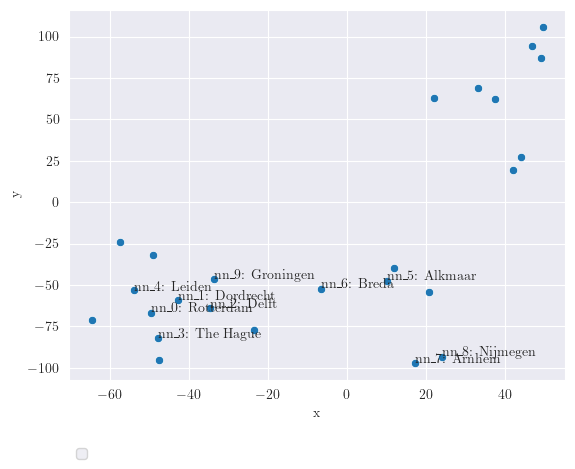

In [13]:
# Provide a simple visualisation of the 25 nearest neighbour set of Rotterdam in embedding 1
sns.scatterplot(x='x', y='y', data=TSNE_df_1)

# Add the labels of the 10 nearest neighbours
for i, (_, row) in enumerate(TSNE_df_1.iloc[:10].iterrows()):
    plt.annotate(f'nn_{i}: {row.label}', (row[0], row[1] + 0.01), weight='bold')
plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.show()

In [14]:
# Get the 25 nearest neighbour set of Rotterdam from embedding 2
nn_in_embed_2 = get_knn_from_target('Rotterdam', embed2_df, 25)

# Get the 10 nearest neighbour set of Rotterdam and Dordrecht in embedding 2
knn_df_embed_2_rotterdam = get_knn_from_target('Rotterdam', embed2_df, 10)
knn_df_embed_2_dordrecht = get_knn_from_target('Dordrecht', embed2_df, 10)

# Determine the overlap between the 10 nearest neighbour sets of rotterdam in embedding 1, and the 10 nearest neighbour sets of Rotterdam and Dordrecht in embedding 2
matching_ids_rotterdam = set(knn_df_embed_2_rotterdam.id.values).intersection(knn_df_embed_1.iloc[:10].id.values)
matching_ids_dordrecht = set(knn_df_embed_2_dordrecht.id.values).intersection(knn_df_embed_1.iloc[:10].id.values)


In [53]:
# Reduce the dimensions from 128 to 25
pca_25_embed_2 = determine_pca_df(nn_in_embed_2, n_components=25)

# Create a t-SNE embedding of the 25 nearest neighbour set of Rotterdam in embedding 2
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(pca_25_embed_2[pca_25_embed_2.columns[:-4]])
TSNE_df_2 = pd.DataFrame(X_embedded, columns=['x', 'y'])
TSNE_df_2[pca_25_embed_1.columns[-4:]] = pca_25_embed_2[pca_25_embed_2.columns[-4:]].values

# Add flags to the DateFrame indicating whether an entity is also part of another set.
TSNE_df_2['in_10nn_rotterdam_embed1'] = TSNE_df_2.id.isin(knn_df_embed_1.iloc[:10].id.values)
TSNE_df_2['in_10nn_dordrecht_embed1'] = TSNE_df_2.id.isin(knn_df_embed_1_dordrecht.id)
TSNE_df_2['in_10nn_rotterdam_embed2'] = TSNE_df_2.id.isin(knn_df_embed_2_rotterdam.id)
TSNE_df_2['in_10nn_dordrecht_embed2'] = TSNE_df_2.id.isin(matching_ids_dordrecht)


# Code for creating the Figure 1 used in 'Do you catch my drift?'

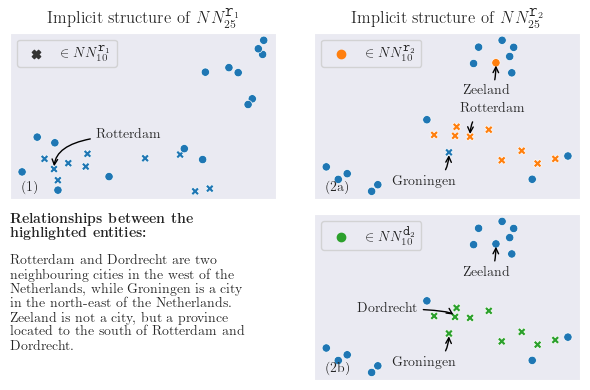

In [74]:
def double_range(list):
    """
    Helper function to double the range of a list, while maintaining the relative distances of the elements within the list.
    :param list: The list that is to be extended
    :return: The left and right most values of the list with double the range.
    """
    mi = min(list)
    ma = max(list)
    abs_diff = (ma-mi)
    c = (ma+mi)/2
    return c-abs_diff, c+abs_diff

# Initialize the figure
fig = plt.figure(figsize=(6, 4))
# Define the grid layout using GridSpec
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# Plot the 25 nearest neighbours of Rotterdam from embedding 1. Style is determined by whether the element is also part of the 10 nearest neighbour set.
ax1 = plt.subplot(gs[0, 0])
sns.scatterplot(ax=ax1, x='x', y='y', style='10nn_rotterdam', data=TSNE_df_1, legend=True)

# Formatting of the first subplot
lines, labels = ax1.get_legend_handles_labels()
labels[1] = r'$\in NN_{10}^{\texttt{r}_1}$'
ax1.legend(lines[1:], labels[1:], loc='upper left')
ax1.set_title(r'Implicit structure of $NN_{25}^{\texttt{r}_1}$')
ax1.annotate('(1)', (min(TSNE_df_1.x), min(TSNE_df_1.y)), weight='bold')

# Adding a label to the 'Rotterdam' entity in the subplot
for i, (_, row) in enumerate(TSNE_df_1.loc[TSNE_df_1.label.isin(['Rotterdam'])].iterrows()):
    ax1.annotate(f'{row.label}', (row[0], row[1]), weight='bold', xytext=(row[0]+20, row[1]+40),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

# Adding some additional explanation about the plot in the current 'vacant' lower left subplot.
ax2 = plt.subplot(gs[1, 0])
ax2.set_axis_off()
header = '\\textbf{Relationships between the} \n\\textbf{highlighted entities:}'
ax2.text(0, 1, header, va='top', ha='left', weight='bold')
txt = 'Rotterdam and Dordrecht are two \nneighbouring cities in the west of the \nNetherlands, while Groningen is a city \nin the north-east of the Netherlands. \nZeeland is not a city, but a province \nlocated to the south of Rotterdam and \nDordrecht.'
ax2.text(0, 0.75, txt, va='top', ha='left')

# Plotting the 25 nearest neighbour set of Rotterdam in embedding 2, while the style is again determined by whether the entity is also part of the 10 nearest neighbour set of Rotterdam in embedding 1, and the color determined by whether the element is part of the 10 nearest neighbour set of Rotterdam in embedding 2.
ax3 = plt.subplot(gs[0, 1])
sns.scatterplot(ax=ax3, x='x', y='y', hue='in_10nn_rotterdam_embed2', style='in_10nn_rotterdam_embed1', data=TSNE_df_2, legend=True)

# Formatting of the upper right subplot.
lines, labels = ax3.get_legend_handles_labels()
labels[2] = r'$\in NN_{10}^{\texttt{r}_2}$'
ax3.legend(lines[2:3], labels[2:3], loc='upper left')
ax3.annotate('(2a)', (min(TSNE_df_2.x), min(TSNE_df_2.y)), weight='bold')
ax3.set_title(r'Implicit structure of $NN_{25}^{\texttt{r}_2}$')

# Plotting the 25 nearest neighbour set of Rotterdam in embedding 2, while the style is again determined by whether the entity is also part of the 10 nearest neighbour set of Rotterdam in embedding 1, and the color determined by whether the element is part of the 10 nearest neighbour set of Dordrecht in embedding 2.
ax4 = plt.subplot(gs[1, 1])
cp = sns.color_palette()
sns.scatterplot(ax=ax4, x='x', y='y', hue='in_10nn_dordrecht_embed2', style='in_10nn_rotterdam_embed1', data=TSNE_df_2, palette=[cp[0],cp[2]], legend=True)

# Formatting of the lower right subplot.
lines, labels = ax4.get_legend_handles_labels()
labels[2] = r'$\in NN_{10}^{\texttt{d}_2}$'
ax4.legend(lines[2:3], labels[2:3], loc='upper left')
ax4.annotate('(2b)', (min(TSNE_df_2.x), min(TSNE_df_2.y)), weight='bold')


# Adding arrows and labels to the 'Rotterdam' entity in the upper right figure.
x_corr = -12 # use this to adjust the x position of the label
y_corr = 50 # use this to adjust the y position of the label
for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Rotterdam'])].iterrows()):
    ax3.annotate(f'{row.label}', (row[0], row[1]), style='italic', xytext=(row[0]+x_corr, row[1]+y_corr),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

# Adding arrows and labels to the 'Zeeland' entity in both the upper and lower right figure.
x_corr = -40 # use this to adjust the x position of the label
y_corr = -70 # use this to adjust the y position of the label
for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Zeeland'])].iterrows()):
    ax3.annotate('Zeeland', (row[0], row[1]), style='italic', xytext=(row[0]+x_corr, row[1]+y_corr),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

    ax4.annotate('Zeeland', (row[0], row[1]), style='italic', xytext=(row[0]+x_corr, row[1]+y_corr),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

# Adding arrows and labels to the 'Groningen' entity in both the upper and lower right figure.
x_corr = -70 # use this to adjust the x position of the label
y_corr = -70 # use this to adjust the y position of the label
for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Groningen'])].iterrows()):
    ax3.annotate('Groningen', (row[0], row[1]), xytext=(row[0]+x_corr, row[1]+y_corr),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

    ax4.annotate('Groningen', (row[0], row[1]), xytext=(row[0]+x_corr, row[1]+y_corr),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

# Adding arrows and labels to the 'Dordrecht' entity in the lower right figure.
x_corr = -120 # use this to adjust the x position of the label
y_corr = 10 # use this to adjust the y position of the label
for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Dordrecht'])].iterrows()):
    ax4.annotate(f'{row.label}', (row[0], row[1]), style='italic', xytext=(row[0]+x_corr, row[1]+y_corr),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

# Removing all x and y labels and ticks.
for a in [ax1, ax2, ax3, ax4]:
    # Hide X and Y axes label marks.
    a.set_xlabel('')
    a.set_ylabel('')

    # Hide X and Y axes tick marks.
    a.set_xticks([])
    a.set_yticks([])


plt.tight_layout()


# plt.savefig('./images/fifth_demo.pdf')
plt.show()

# Below is the code used for creating previous iterations of the graph. This code has not been tested and might no longer be functional, but could be used for inspiration on creating other visuals.

In [7]:
location_object_set = set()

for obj_list in rel_df.objects:
    location_object_set = location_object_set.union(set(obj_list))

# print([get_label(l) for l in location_object_set])


In [7]:
subset_embed_df = embed_df[embed_df['id'].isin(location_object_set)]

In [142]:
knn_df = get_knn_from_target('Amsterdam', embed_df, 15)
pca_df = determine_pca_df(knn_df)
print(pca_df)

        pc_0      pc_1                        label        id    idx  \
0   0.867253 -0.134186                    Amsterdam   /m/0k3p   7971   
1  -0.322169 -0.742668                    The Hague  /m/07g0_  10062   
2   0.066290  0.485842                      Alkmaar  /m/0ps8c  10445   
3  -0.631400 -0.259678                    Dordrecht  /m/0jcx1  12672   
4   0.454343  0.455977                    Hilversum  /m/03kfl  13154   
5  -0.597641 -0.445883                    Rotterdam  /m/06hdk   8906   
6   0.084312  0.690966                      Haarlem  /m/0h095   3153   
7  -0.622920 -0.421688                        Delft  /m/029t1  12915   
8   0.012177  0.892677                    Eindhoven  /m/02kx3  14110   
9  -0.696521 -0.375034                       Leiden  /m/0cl8c  13392   
10 -0.339225  0.613016                       Arnhem  /m/0flsf  13642   
11  1.733389 -0.332641                    Frankfurt  /m/02z0j   8696   
12  0.540950 -0.782131  Groningen (Netherlands) #20  /m/0d8rs   

In [10]:
interst_capitals = ['Berlin', 'Amsterdam', 'Beirut', 'Edinburgh', 'Stockholm', 'San Juan', 'Vatican City', 'Singapore', 'Washington, D.C.', 'Richmond', 'Constantinople']
knn_df = get_knn_from_target('Amsterdam', embed_df, 15)
pca_df = determine_pca_df(knn_df)
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='pc_0', y='pc_1', data=pca_df)
capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, (_, row) in enumerate(pca_df.iterrows()):
    print(row)
    plt.annotate(f'nn_{i}: {row.label}', (row[0], row[1] + 0.01), weight='bold')
plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pc_0                      0.867253
pc_1                     -0.134186
label                    Amsterdam
id                         /m/0k3p
idx                           7971
group    /location/country/capital
Name: 0, dtype: object
pc_0                     -0.322169
pc_1                     -0.742668
label                    The Hague
id                        /m/07g0_
idx                          10062
group    /location/country/capital
Name: 1, dtype: object
pc_0      0.06629
pc_1     0.485842
label     Alkmaar
id       /m/0ps8c
idx         10445
group        None
Name: 2, dtype: object
pc_0       -0.6314
pc_1     -0.259678
label    Dordrecht
id        /m/0jcx1
idx          12672
group         None
Name: 3, dtype: object
pc_0                                              0.454343
pc_1                                              0.455977
label                                            Hilversum
id                                                /m/03kfl
idx                           

RuntimeError: latex was not able to process the following string:
b'nn_12: Groningen (Netherlands) #20'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpiih2744g 6e77ff643baf5df154a91722bdf1566f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./6e77ff643baf5df154a91722bdf1566f.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 6e77ff643baf5df154a91722bdf1566f.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.30 {\rmfamily nn_12: Groningen (Netherlands) #
                                                20}%
No pages of output.
Transcript written on tmpiih2744g/6e77ff643baf5df154a91722bdf1566f.log.




<Figure size 800x600 with 1 Axes>

In [8]:

predicates_of_interest= ['/location/country/capital','/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']

location_object_set = set()
for obj_list in rel_df[rel_df.predicate.isin(predicates_of_interest)].objects:
    location_object_set = location_object_set.union(set(obj_list))

subset_embed_df = embed_df[embed_df['id'].isin(location_object_set)]
# predicates_of_interest=list(rel_df.predicate.values)[:10]
target_vec = subset_embed_df.loc[subset_embed_df.label == 'Amsterdam'][subset_embed_df.columns[3:]].values
_, nn = det_KNN(target_vec, subset_embed_df[subset_embed_df.columns[3:]].values)

subset_embed_df = subset_embed_df.iloc[nn[0]]

# sorted_embed_df = embed_df.sort_values(by='idx')

complete_df = subset_embed_df[[0,1]]
complete_df['label'] = subset_embed_df['label'].values
complete_df['id'] = subset_embed_df['id'].values
groups = [get_groups(id, rel_df, predicates_of_interest) for id in complete_df.id.values]
for g in groups:
    print(g)
main_group = [g[0] if len(g)>0 else None for g in groups]
complete_df['group'] = main_group

['/location/country/capital', '/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/location/country/capital']
['/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/organization/organization/headquarters./location/mailing_address/citytown']
['/organization/organization/headquarters./location/mailing_address/citytown']
['/location/country/capital', '/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/organization/organization/headquarters./location/mailing_address/citytown']
['/location/country/capital', '/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/people/person/places_lived./people/place_lived/location']
['/location/country/capital']

/tmp/ipykernel_3127/4064277452.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df['label'] = subset_embed_df['label'].values
/tmp/ipykernel_3127/4064277452.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df['id'] = subset_embed_df['id'].values
/tmp/ipykernel_3127/4064277452.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

/tmp/ipykernel_29823/1069173076.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


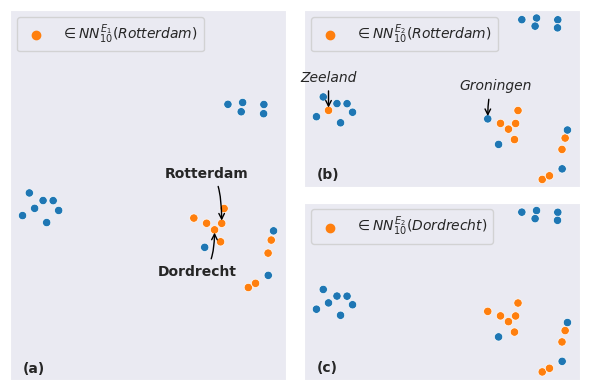

In [191]:
# ax.annotate(n[1], (z[1], y[1]), xytext=(z[1]-0.05, y[1]-0.3),
#     arrowprops = dict(  arrowstyle="->",
#                         connectionstyle="angle3,angleA=0,angleB=-90"))
# pca2_df = determine_pca_df(nn_embed_2)
def double_range(list):
    mi = min(list)
    ma = max(list)
    abs_diff = (ma-mi)
    c = (ma+mi)/2
    return c-abs_diff, c+abs_diff

fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(6, 4), layout="constrained")

# fig, ax = plt.subplots(1,2, figsize=(6,4))
sns.scatterplot(ax=axd['left'], x='x', y='y', hue='in_10nn_rotterdam_embed1', data=TSNE_df_2, legend=True)

axd['left'].set_ylim(double_range(TSNE_df_2.y))
lines, labels = axd['left'].get_legend_handles_labels()
# labels[0] = r'$\notin NN_{10}^{E_1}(Rotterdam)$'
labels[1] = r'$\in NN_{10}^{E_1}(Rotterdam)$'
axd['left'].legend(lines[1:], labels[1:], loc='upper left')


for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Rotterdam', 'Dordrecht'])].iterrows()):
    # print(row)
    axd['left'].annotate(f'{row.label}', (row[0], row[1]), weight='bold', xytext=(row[0]-50, row[1]-70*(-0.5+i)),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))

axd['left'].annotate('(a)', (min(TSNE_df_2.x), double_range(TSNE_df_2.y)[0]+5), weight='bold')

sns.scatterplot(ax=axd['upper right'], x='x', y='y', hue='in_10nn_rotterdam_embed2', data=TSNE_df_2, legend=True)

for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Zeeland', 'Groningen'])].iterrows()):
    # print(row)
    axd['upper right'].annotate(f'{row.label}', (row[0], row[1]), style='italic', xytext=(row[0]-25, row[1]+25),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))
lines, labels = axd['upper right'].get_legend_handles_labels()
labels[1] = r'$\in NN_{10}^{E_2}(Rotterdam)$'
axd['upper right'].legend(lines[1:], labels[1:], loc='upper left')
axd['upper right'].annotate('(b)', (min(TSNE_df_2.x), min(TSNE_df_2.y)), weight='bold')


sns.scatterplot(ax=axd['lower right'], x='x', y='y', hue='in_10nn_dordrecht_embed2', data=TSNE_df_2, legend=True)


lines, labels = axd['lower right'].get_legend_handles_labels()
labels[1] = r'$\in NN_{10}^{E_2}(Dordrecht)$'
axd['lower right'].legend(lines[1:], labels[1:], loc='upper left')
axd['lower right'].annotate('(c)', (min(TSNE_df_2.x), min(TSNE_df_2.y)), weight='bold')


for a in axd:
    # Hide X and Y axes label marks
    # a.xaxis.set_tick_params(labelbottom=False)
    # a.yaxis.set_tick_params(labelleft=False)

    axd[a].set_xlabel('')
    axd[a].set_ylabel('')

    # Hide X and Y axes tick marks
    axd[a].set_xticks([])
    axd[a].set_yticks([])

# plt.suptitle(r"t-SNE visualisation of $NN_{25}^{E_2}(Rotterdam)$")

plt.tight_layout()

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# labels[0] = r'In $NN_{10}^c$ embedding 1'
# labels[3] = r'In $NN_{10}^c$ embedding 2'
# ax[1].legend(lines, labels, ncol=2, loc='center left', bbox_to_anchor=[-0.85, -0.2])





# plt.gcf().set_size_inches(10, 10)
plt.savefig('./images/second_demo.pdf')
plt.show()

In [139]:
lines_labels

([<matplotlib.collections.PathCollection at 0x7fda0b0565c0>,
 ['False', 'True'])

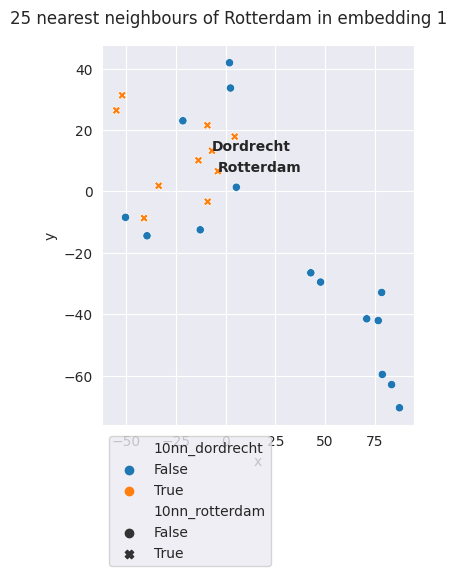

In [24]:
# pca2_df = determine_pca_df(nn_embed_2)
fig, ax = plt.subplots(1,1, figsize=(4,6))
sns.scatterplot(ax=ax, x='x', y='y', style='10nn_rotterdam', hue='10nn_dordrecht', data=TSNE_df_1)
# capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, (_, row) in enumerate(TSNE_df_1.loc[TSNE_df_1.label.isin(['Rotterdam'])].iterrows()):
    # print(row)
    ax.annotate(f'{row.label}', (row[0], row[1] + 0.00), weight='bold')

for i, (_, row) in enumerate(TSNE_df_1.loc[TSNE_df_1.label.isin(['Dordrecht'])].iterrows()):
    # print(row)
    ax.annotate(f'{row.label}', (row[0], row[1] + 0.00), weight='bold')

ax.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
# ax.set_title('10 nearest neighbours of Rotterdam \nin embedding 1', size=8)

# plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.suptitle('25 nearest neighbours of Rotterdam in embedding 1')
plt.tight_layout()
# plt.savefig('./images/first_demo.png')
plt.show()

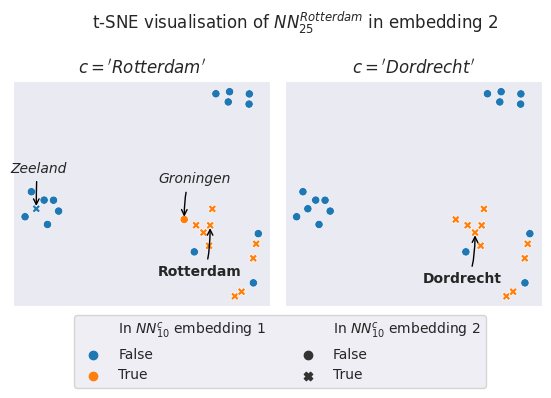

In [127]:
# ax.annotate(n[1], (z[1], y[1]), xytext=(z[1]-0.05, y[1]-0.3),
#     arrowprops = dict(  arrowstyle="->",
#                         connectionstyle="angle3,angleA=0,angleB=-90"))
# pca2_df = determine_pca_df(nn_embed_2)
fig, ax = plt.subplots(1,2, figsize=(6,4))
sns.scatterplot(ax=ax[0], x='x', y='y', style='in_10nn_rotterdam_embed2', hue='in_10nn_rotterdam_embed1', data=TSNE_df_2, legend=False)
# capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Rotterdam'])].iterrows()):
    # print(row)
    ax[0].annotate(f'{row.label}', (row[0], row[1]), weight='bold', xytext=(row[0]-50, row[1]-35),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))
for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Zeeland', 'Groningen'])].iterrows()):
    # print(row)
    ax[0].annotate(f'{row.label}', (row[0], row[1]), style='italic', xytext=(row[0]-25, row[1]+25),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))
# ax[0].legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
ax[0].set_title(r"$c='Rotterdam'$", size=12)

sns.scatterplot(ax=ax[1], x='x', y='y', style='in_10nn_dordrecht_embed2', hue='in_10nn_dordrecht_embed1', data=TSNE_df_2, legend=True)

for i, (_, row) in enumerate(TSNE_df_2.loc[TSNE_df_2.label.isin(['Dordrecht'])].iterrows()):
    # print(row)
    ax[1].annotate(f'{row.label}', (row[0], row[1] + 0.00), weight='bold', xytext=(row[0]-50, row[1]-35),
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",
                        color='black'))
# ax[1].legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
ax[1].set_title(r"$c='Dordrecht'$", size=12)
ax[1].legend(loc='center left', bbox_to_anchor=[0, -0.05])


for a in ax:
    # Hide X and Y axes label marks
    # a.xaxis.set_tick_params(labelbottom=False)
    # a.yaxis.set_tick_params(labelleft=False)

    a.set_xlabel('')
    a.set_ylabel('')

    # Hide X and Y axes tick marks
    a.set_xticks([])
    a.set_yticks([])

plt.suptitle(r't-SNE visualisation of $NN_{25}^{Rotterdam}$ in embedding 2')

plt.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels[0] = r'In $NN_{10}^c$ embedding 1'
labels[3] = r'In $NN_{10}^c$ embedding 2'
ax[1].legend(lines, labels, ncol=2, loc='center left', bbox_to_anchor=[-0.85, -0.2])





# plt.gcf().set_size_inches(10, 10)
plt.savefig('./images/first_demo.pdf')
plt.show()

In [74]:

ax[0].xlabel

AttributeError: 'Axes' object has no attribute 'xlabel'

In [38]:
labels

['in_10nn_dordrecht_embed1',
 'False',
 'True',
 'in_10nn_dordrecht_embed2',
 'False',
 'True']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


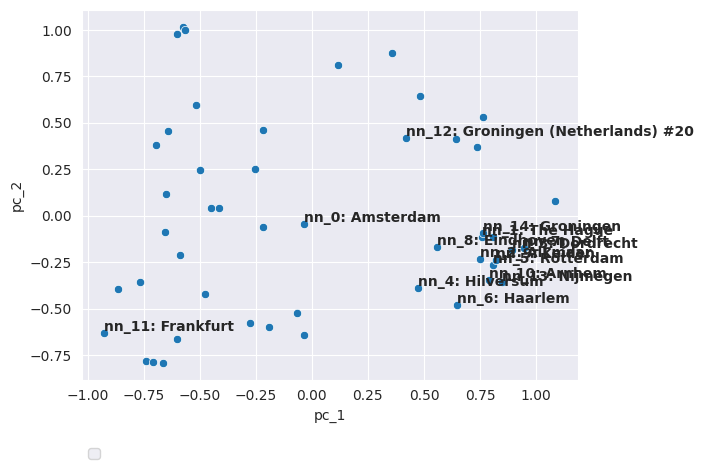

In [50]:
sns.scatterplot(x='pc_1', y='pc_2', data=pca_df)
# capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, (_, row) in enumerate(pca_df.iloc[:1 5].iterrows()):
    # print(row)
    plt.annotate(f'nn_{i}: {row.labels}', (row[0], row[1] + 0.01), weight='bold')
plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.show()

In [119]:
print(embed1_df.loc[embed1_df.idx != embed2_df.idx])

Empty DataFrame
Columns: [id, label, idx, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, ...]
Index: []

[0 rows x 131 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pc_1                       0.867253
pc_2                      -0.134186
labels                    Amsterdam
id                          /m/0k3p
group     /location/country/capital
Name: 0, dtype: object
pc_1                      -0.322169
pc_2                      -0.742668
labels                    The Hague
id                         /m/07g0_
group     /location/country/capital
Name: 1, dtype: object
pc_1       0.06629
pc_2      0.485842
labels     Alkmaar
id        /m/0ps8c
group         None
Name: 2, dtype: object
pc_1        -0.6314
pc_2      -0.259678
labels    Dordrecht
id         /m/0jcx1
group          None
Name: 3, dtype: object
pc_1                                               0.454343
pc_2                                               0.455977
labels                                            Hilversum
id                                                 /m/03kfl
group     /organization/organization/headquarters./locat...
Name: 4, dtype: object
pc_1      -0.597641
pc_2      

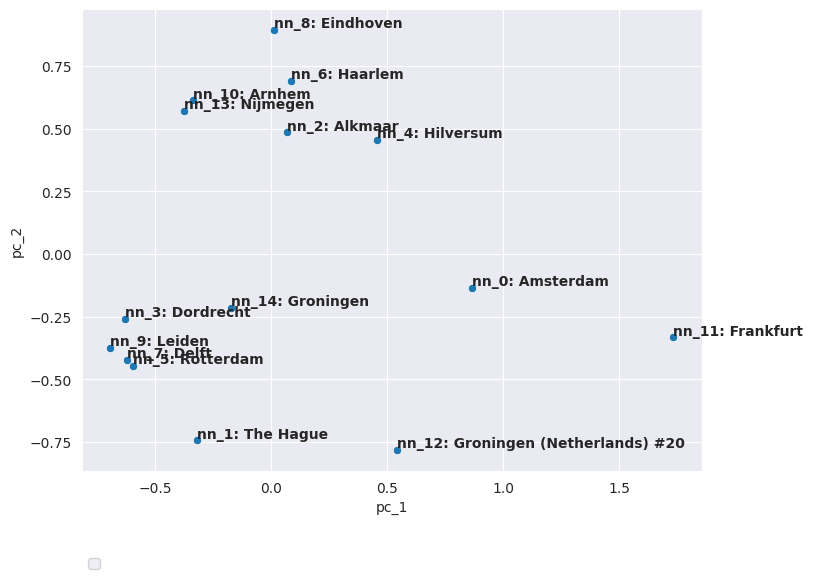

In [113]:
embed_df = get_embed_df('./data/fb15K/fb15k_rescal_base_1.pkl')
knn_df = get_knn_from_target('Amsterdam', embed_df, 15)
pca_df = determine_pca_df(knn_df)
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='pc_1', y='pc_2', data=pca_df)
capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, (_, row) in enumerate(pca_df.iterrows()):
    print(row)
    plt.annotate(f'nn_{i}: {row.labels}', (row[0], row[1] + 0.01), weight='bold')
plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.show()

In [30]:
from sklearn.decomposition import PCA

predicates_of_interest= ['/location/country/capital','/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']

location_object_set = set()
for obj_list in rel_df[rel_df.predicate.isin(predicates_of_interest)].objects:
    location_object_set = location_object_set.union(set(obj_list))

subset_embed_df = embed_df[embed_df['id'].isin(location_object_set)]
# predicates_of_interest=list(rel_df.predicate.values)[:10]
target_vec = subset_embed_df.loc[subset_embed_df.label == 'Amsterdam'][subset_embed_df.columns[3:]].values
_, nn = det_KNN(target_vec, subset_embed_df[subset_embed_df.columns[3:]].values, 15)

pca = PCA(n_components=2)
# sorted_embed_df = embed_df.sort_values(by='idx')
m = subset_embed_df[subset_embed_df.columns[3:]]
m_reduced = pca.fit_transform(m)
pca_df = pd.DataFrame(m_reduced, columns=['pc_1', 'pc_2'])
pca_df['labels'] = subset_embed_df['label'].values
pca_df['id'] = subset_embed_df['id'].values
groups = [get_groups(id, rel_df, predicates_of_interest) for id in pca_df.id.values]
for g in groups:
    print(g)
main_group = [g[0] if len(g)>0 else None for g in groups]
pca_df['group'] = main_group

['/organization/organization/headquarters./location/mailing_address/citytown']
['/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/location/country/capital', '/organization/organization/headquarters./location/mailing_address/citytown']
['/location/country/capital', '/organization/organization/headquarters./location/mailing_address/citytown']
['/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/people/person/places_lived./people/place_lived/location']
['/people/person/places_lived./people/place_lived/location']
['/people/person/places_lived./people/place_lived/location']
['/organization/organization/headquarters./location/mailing_address/citytown', '/people/person/places_lived./people/place_lived/location']
['/people/person/places_lived./people/place_lived/location']
['/organization/organization/headquarters./l

In [ ]:
nn[0]

pc_1                       3.448146
pc_2                       2.689429
labels                    Amsterdam
id                          /m/0k3p
group     /location/country/capital
Name: 24, dtype: object
pc_1                                                5.66507
pc_2                                               7.868609
labels                                          Netherlands
id                                                 /m/059j2
group     /people/person/places_lived./people/place_live...
Name: 568, dtype: object
pc_1                       4.312976
pc_2                       -1.77122
labels                    The Hague
id                         /m/07g0_
group     /location/country/capital
Name: 841, dtype: object
pc_1                                               4.132531
pc_2                                              -1.404516
labels                                            Hilversum
id                                                 /m/03kfl
group     /organization/or

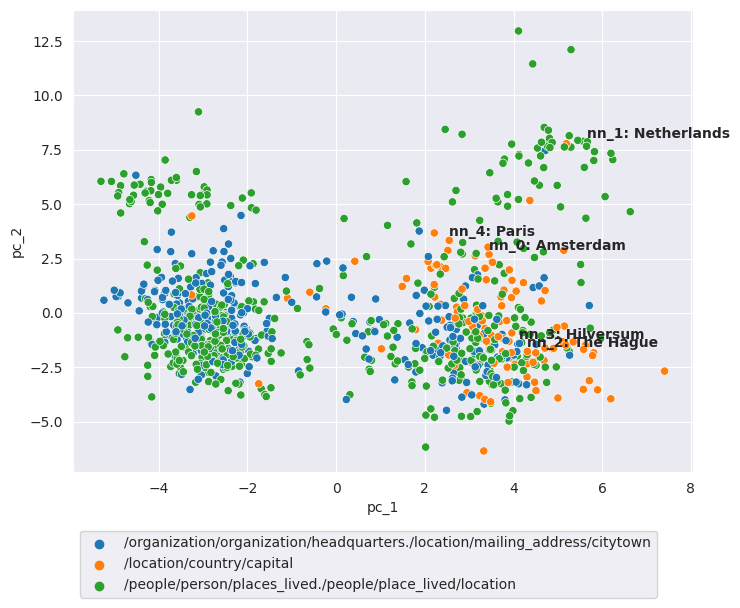

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

interst_capitals = ['Berlin', 'Amsterdam', 'Beirut', 'Edinburgh', 'Stockholm', 'San Juan', 'Vatican City', 'Singapore', 'Washington, D.C.', 'Richmond', 'Constantinople']

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='pc_1', y='pc_2', hue='group', data=pca_df)
capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, (_, row) in enumerate(pca_df.iloc[nn[0]].iterrows()):
    print(row)
    plt.annotate(f'nn_{i}: {row.labels}', (row.pc_1, row.pc_2 + 0.2), weight='bold')
plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.show()

In [ ]:
subset_embed_df.loc[subset_embed_df.label == 'Amsterdam']

In [ ]:
[get_groups(id, rel_df, list(rel_dict.values())) for id in pca_df.id.values]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

interst_capitals = ['Berlin', 'Amsterdam', 'Beirut', 'Edinburgh', 'Stockholm', 'San Juan', 'Vatican City', 'Singapore', 'Washington, D.C.', 'Richmond', 'Constantinople']

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='pc_1', y='pc_2', hue='group', data=pca_df)
capitals = pca_df.loc[pca_df.group == '/location/country/capital']
for i, row in capitals.loc[capitals.labels.isin(interst_capitals)].iterrows():
    print(row)
    plt.annotate(row.labels, (row.pc_1, row.pc_2 + 0.2))
plt.legend(loc='center left', bbox_to_anchor=[0.0, -0.2])
plt.show()

In [ ]:
pca_df